In [2]:
import os,sys
import numpy as np
import argparse
import collections
from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection, PatchCollection
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

In [3]:
plt.rcParams['svg.fonttype'] = 'none'

In [5]:
seq_lengths = np.array([int(l.split()[1]) for l in open('output/hg_chr8.lengths', 'r').read().splitlines()])
NUM_SEQ = len(seq_lengths)

In [6]:
mums = [l.split() for l in open('output/hg_chr8.mums', 'r').read().splitlines()]
mums = [(int(l[0]), np.array([int(v) for v in l[1].split(',')]), tuple(l[2].split(','))) for l in mums]

In [7]:
def find_coll_blocks(mums, MAX_BREAK=10000):
    starts = np.array([m[1] for m in mums])
    mum_orders = starts.transpose().argsort()
    mum_gaps = []
    flips = set([])
    for i in range(mum_orders.shape[0]):
        cur = []
        for l in range(1, mum_orders.shape[1]):
            left, right = mum_orders[i][l-1], mum_orders[i][l]
            if mums[left][2][i] == mums[right][2][i]:
                if mums[left][2][i] == '+':
                    cur.append((left, right))
                else:
                    cur.append((right, left))
                    flips.add((right, left))
        mum_gaps.append(cur)
    common_gaps = set.intersection(*map(set, mum_gaps))
    left, right = zip(*common_gaps)
    left, right = set(list(left)), set(list(right))
    true_collinear_mums = sorted(list(left.intersection(right)))
    right_coll_mums = sorted(list(left.difference(set(true_collinear_mums)))) # have a right pair, but not a left
    left_coll_mums = sorted(list(right.difference(set(true_collinear_mums)))) # have a left pair, but not a right
    large_blocks = list(zip(right_coll_mums, left_coll_mums))
    ### find the longest stretches of collinear mums
    small_blocks = []
    for l, r in large_blocks:
        last = l
        for i in range(l, r):
            lens = np.full(len(mums[i][1]), mums[i][0])
            lens[(mums[i+1][1] < mums[i][1])] = mums[i+1][0] 
            gap_lens = np.abs(mums[i][1] - mums[i+1][1]) - lens
            if gap_lens.max() > MAX_BREAK and last < i:
                small_blocks.append((last, i))
                last = i + 1
        if last != r:
            small_blocks.append((last, r))
    return large_blocks, small_blocks

In [8]:
def get_block_order(mums, blocks):
    starts = np.array([m[1] for m in mums])
    mum_orders = starts.transpose().argsort()
    ### get coll_block order
    coll_block_starts = [b[0] for b in blocks]
    coll_block_orders = []
    for i in range(mum_orders.shape[0]):
        poi = np.where(np.isin(mum_orders[i], coll_block_starts))[0]
        values = mum_orders[i][poi]
        poi = np.argsort(values)
        coll_block_orders.append(np.argsort(poi))
    return coll_block_orders

In [9]:
large_blocks, small_blocks = find_coll_blocks(mums, MAX_BREAK=1000)
coll_block_order = get_block_order(mums, small_blocks)

The following code blocks compute the same inverted regions that `mumemto inversion` does

In [10]:
def draw_synteny_outline_inv(genome_lengths, mums, outlines, contig_breaks=None, inv_ranges=None, mum_color='red', inv_color='green'):
    def points_to_poly(points):
        starts, ends = tuple(zip(*points))
        points = starts + ends[::-1]
        return points
    fig, ax = plt.subplots()
    max_length = max(genome_lengths)
    for idx, g in enumerate(genome_lengths):
        ax.plot([0, g], [idx, idx], color='gray', alpha=0.2, linewidth=0.5)
        if contig_breaks and idx > 0:
            offset = 0
            for c in contig_breaks[idx-1]:
                ax.plot([offset + c, offset + c], [idx-0.1, idx+0.1], color='blue', alpha=1, linewidth=0.5)
                offset += c
    if inv_ranges:
        rects = []
        for i, s, e in inv_ranges:
            width = e - s
            height = 0.5  # since it's from i-0.5 to i+0.5
            rect = patches.Rectangle((s, i - 0.25), width, height)
            rects.append(rect)
        ax.add_collection(PatchCollection(rects, linewidth=0, facecolor='blue', alpha=0.3))
    polygons = []
    colors = []
    for _, (l, r) in enumerate(outlines):
        strands = mums[l][2]
        inverted = strands[0] == '-'
        points = []
        left, right = mums[l][1], mums[r][1] + mums[r][0]
        for idx, strand in enumerate(strands):
            points.append(((left[idx], idx), (right[idx], idx)))
            if not inverted and strand == '-':
                inverted = True
                if len(points) > 2:
                    polygons.append(points_to_poly(points[:-1]))
                    colors.append(mum_color)
                polygons.append(points_to_poly(points[-2:]))
                colors.append(inv_color)
                points = [points[-1]]
            elif inverted and strand == '+':
                inverted = False
                if len(points) > 2:
                    polygons.append(points_to_poly(points[:-1]))
                    colors.append(mum_color)
                polygons.append(points_to_poly(points[-2:]))
                colors.append(inv_color)
                points = [points[-1]]
        if len(points) >= 2:
            polygons.append(points_to_poly(points))
            colors.append(mum_color)
    ax.add_collection(PolyCollection(polygons, linewidths=0, alpha=0.7, edgecolors=colors, facecolors=colors))
    
    ax.yaxis.set_ticks(range(len(genome_lengths)))
    ax.tick_params(axis='y', which='both',length=0)
    ax.yaxis.set_ticklabels([])
    ax.set_xlabel('bp')
    ax.set_ylabel('sequences')
    ax.set_ylim(0, len(genome_lengths)-1)
    ax.set_xlim(0, max_length)
    return fig, ax

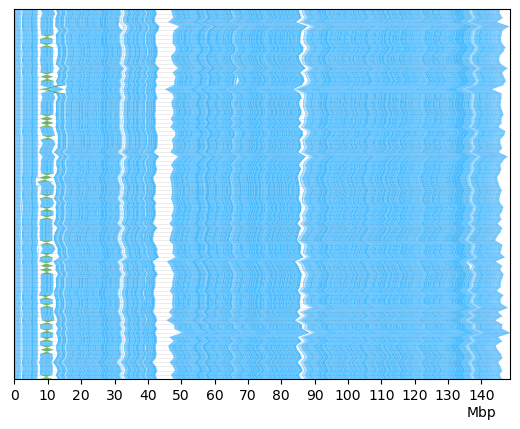

In [ ]:
fig, ax = draw_synteny_outline_inv(seq_lengths, mums, small_blocks, mum_color='#00A2FF')
ax.set_ylabel('')
ax.set_xlabel('')
ax.xaxis.set_major_formatter(lambda x, _: f'{int(x/1e6)}' if int(x/1e6) <140 else f'{int(x/1e6)}\nMbp')
ax.xaxis.set_ticks(range(0, int(seq_lengths[0]), 10000000));

In [17]:
coverage = np.load('output/hg_chr8_coverage.npy')

/tmp/ipykernel_2724531/67612882.py:13: RuntimeWarning: divide by zero encountered in log
  masked_mean_cov = np.ma.masked_where(np.log(mean_cov) < 6, np.log(mean_cov))


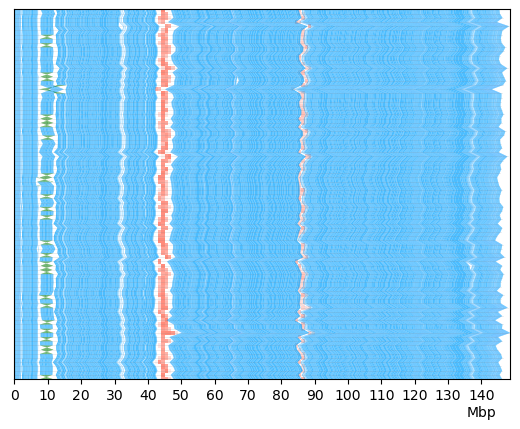

In [51]:
split = 1000000
heat_start = 0
heat_width = coverage.shape[1]
mean_cov = np.stack([coverage[:, i*split:(i+1)*split].mean(axis=1) for i in range(heat_width//split)]).T
cmap_colors = [(1, 1, 1), (1, 0.392, 0.306)]
cmap = LinearSegmentedColormap.from_list('custom_cmap', cmap_colors)

x = np.linspace(heat_start, heat_start + heat_width, mean_cov.shape[1] + 1)
y = np.linspace(-0.5, len(seq_lengths)-0.5, mean_cov.shape[0] + 1)

masked_mean_cov = np.ma.masked_where(np.log(mean_cov) < 6, np.log(mean_cov))
heat = ax.pcolormesh(x, y, masked_mean_cov, cmap=cmap, alpha=0.75, shading='auto', zorder=0)
heat.set_clim(6, 10)

fig